In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import json
import numpy as np
import jax
import jax.numpy as jnp
import flax
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import timecast as tc

from mpl_toolkits import mplot3d

plt.rcParams['figure.figsize'] = [20, 10]

import tqdm.notebook as tqdm

/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import pickle

import timecast as tc
import pandas as pd
import matplotlib.pyplot as plt

import flax
import jax.numpy as jnp
import numpy as np

from timecast.learners import AR
from timecast.utils.ar import historify, compute_gram

In [3]:
data = jnp.array(pd.read_csv("../data/wind/original/MS_winds.dat", names=list(range(57))))
pickle.dump(data, open("../data/wind/original/MS_winds.pkl", "wb"))

In [4]:
# Columns = 57 stations
# Rows = wind speed readings (m/s)
data

DeviceArray([[5.0963, 2.0564, 3.0399, ..., 3.0399, 3.5763, 2.5481],
             [5.0963, 1.5199, 2.5481, ..., 2.5481, 3.5763, 2.5481],
             [5.588 , 1.5199, 2.0564, ..., 2.5481, 3.5763, 1.5199],
             ...,
             [4.6045, 4.0681, 5.0963, ..., 4.6045, 0.    , 3.0399],
             [7.1526, 6.1244, 4.6045, ..., 4.0681, 0.    , 4.0681],
             [7.1526, 3.5763, 3.0399, ..., 4.0681, 0.    , 4.6045]],            dtype=float32)

In [5]:
# Normalization
# NOTE: This is a bug; they claim this normalizes from 0 to 1, but it doesn't
# NOTE: Their variable also refer to min and max as mean and std, respectively so...
data_min = data.min()
data_max = data.max()
data = (data - data_min) / data_max

In [6]:
models = pickle.load(open("../data/wind/original/models.pkl", "rb"))["models"]

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [7]:
# Mostly from https://github.com/amirstar/Deep-Forecast/blob/4dcdf66f8ae3070ab706b30a6e3cf888f36e0536/multiLSTM.py#L210
def predict(X, models):
    X = X.reshape(X.shape[0], history_len, num_stations)
    results = np.zeros_like(np.zeros((X.shape[0], num_stations)))
    
    for ind in range(len(X)):
        modelInd = ind % 6
        if modelInd == 0:
            testInputRaw = X[ind]
            testInputShape = testInputRaw.shape
            testInput = np.reshape(testInputRaw, [1, testInputShape[0], testInputShape[1]])
        else:
            testInputRaw = np.vstack((testInputRaw, results[ind-1]))
            testInput = np.delete(testInputRaw, 0, axis=0)
            testInputShape = testInput.shape
            testInput = np.reshape(testInput, [1, testInputShape[0], testInputShape[1]])
    
        pred = models[modelInd].predict(testInput)
        results[ind] = pred

    return jnp.array(results)

In [8]:
num_train = 6000
num_test = 361

history_len = 12
num_stations = 57

In [9]:
# 12..5999
train_true = data[history_len:num_train]
# 0..11, 1..12, ..., 5987..5998
train_data = historify(data, history_len=history_len, num_histories=train_true.shape[0])

# 6012..8386
test_true = data[num_train + history_len:]
# 6000..6011, ..., 8374..8385
test_data = historify(data, history_len=history_len, num_histories=test_true.shape[0], offset=num_train)

In [10]:
# 6012..8386
test_pred = predict(test_data, models)

In [11]:
data.shape

(8387, 57)

In [12]:
# Metric: mean absolute error
jnp.absolute((test_true - test_pred) * data_max + data_min).mean(axis=0).mean()

DeviceArray(1.3113904, dtype=float32)

In [13]:
# 12..5999
train_pred = predict(train_data, models)

In [14]:
train_pred.shape

(5988, 57)

In [15]:
# 1..5998
train_pred = jnp.vstack((jnp.zeros((history_len - 1, num_stations)), train_pred))

In [18]:
# 6001..8385
test_pred = jnp.vstack((jnp.zeros((history_len - 1, num_stations)), test_pred))

In [23]:
test_true = jnp.vstack((jnp.zeros((history_len - 1, num_stations)), test_true))
test_resid = test_true - test_pred

In [24]:
test_resid.shape

(2386, 57)

In [19]:
print(test_pred.shape, test_data.shape)

(2386, 57) (2375, 684)


In [21]:
data[num_train:-1].shape

(2386, 57)

In [22]:
test_true.shape

(2375, 57)

In [20]:
print(train_pred.shape, train_data.shape)

(5999, 57) (5988, 684)


In [25]:
ars, states = [None] * num_stations, [None] * num_stations
for station in tqdm.tqdm(range(num_stations)):
    ars[station], states[station] = AR.fit(
        data=[(data[num_train:-1], test_resid[:, station], None)],
        input_dim=num_stations,
        output_dim=1,
        history=data[num_train : num_train + history_len],
        history_len=history_len
    )

In [30]:
test_pred[10:, 0].shape

(2376,)

In [31]:
data[num_train + history_len - 1:-1].shape

(2375, 57)

In [73]:
from timecast.learners import BlackBox, Parallel
from timecast.optim import GradientDescent
from timecast import tmap
from timecast.objectives import residual

lr = -5

In [76]:
results = {}
for station in tqdm.tqdm(range(num_stations)):
    Y_lstm = test_pred[history_len - 1:, station]
    X = data[num_train + history_len - 1:-1]
    Y = data[num_train + history_len:, station]
    
    lstm = BlackBox.partial(arr=Y_lstm)
    model, state = Parallel.new(shape=(1, num_stations), learners=[lstm, ars[station].module])
#     model.params["AR"] = ars[station].params
    
    optim_def = GradientDescent(learning_rate=(10 ** lr))
    optimizer = optim_def.create(model)
    
#     Y_hat, optimizer, state = tmap(X, Y, optimizer, state=state, objective=residual)
    jax.vmap
    results[station] = jnp.absolute((Y - Y_hat) * data_max + data_min).mean()
#     break

/home/dsuo/miniconda3/envs/skgaip/lib/python3.7/site-packages/jax/lax/lax.py:5104: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [84]:
with flax.nn.stateful(states[station]) as state:
#     jax.vmap(lambda x: ars[station](x))(X)
    a = ars[station](X[1,:])

In [88]:
def blah(x):
    with flax.nn.stateful(states[station]) as state:
        return ars[station](x)

In [89]:
jax.vmap(blah)(X)

DeviceArray([[-0.42126814],
             [-0.16777693],
             [-0.22932234],
             ...,
             [-0.21381599],
             [-0.1034736 ],
             [ 0.457838  ]], dtype=float32)

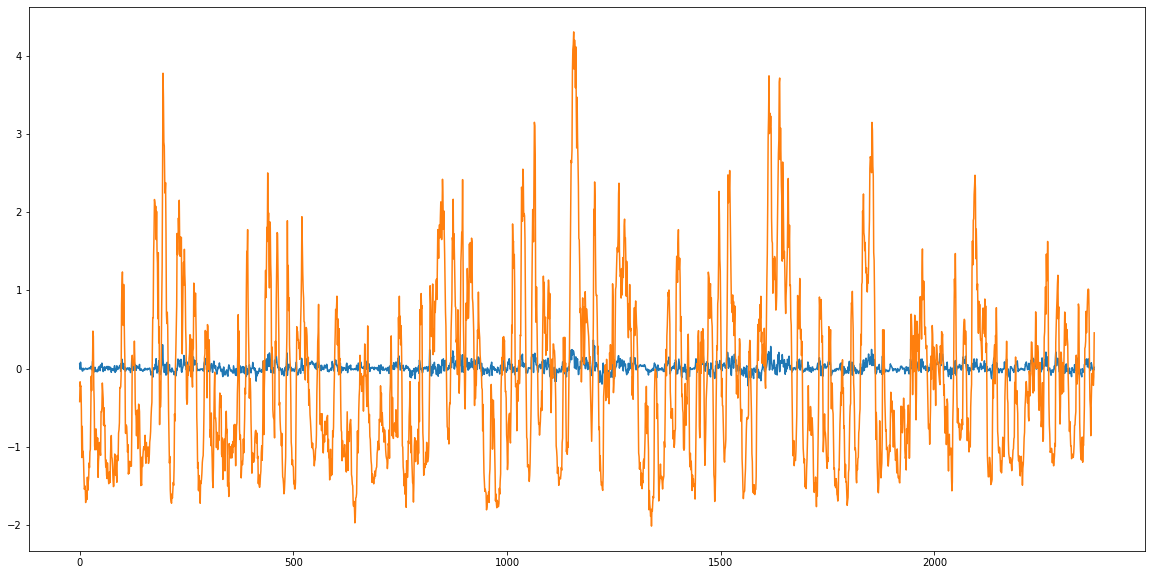

In [90]:
plt.plot(Y-Y_lstm)
plt.plot(jax.vmap(blah)(X))


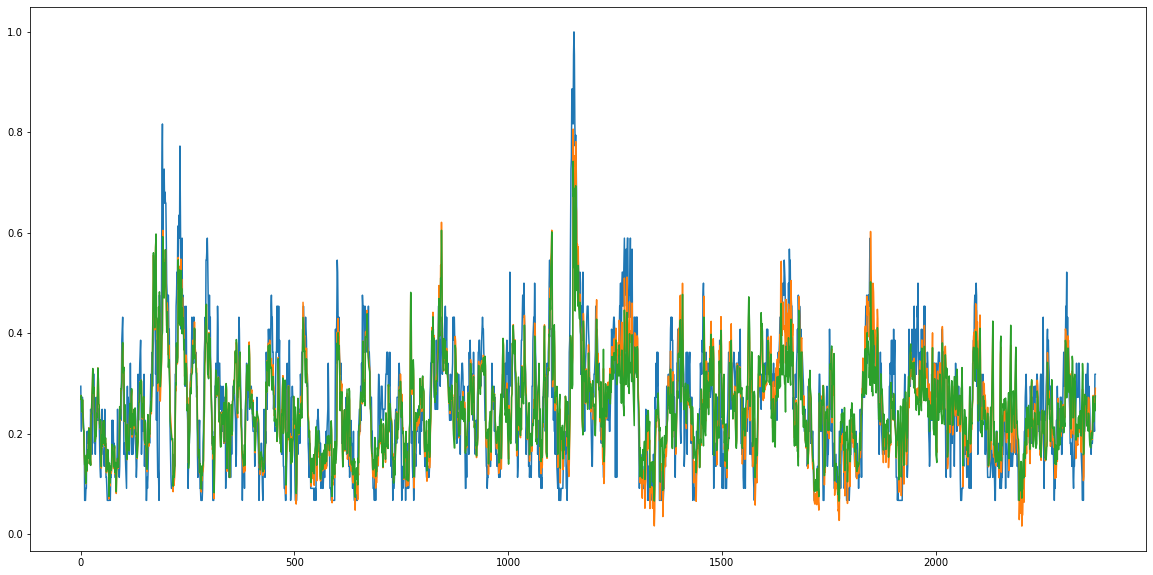

In [75]:
plt.plot(Y)
plt.plot(Y_hat)
plt.plot(Y_lstm)
# plt.plot(test_resid[history_len - 1:, station])
# plt.plot(Y - Y_lstm)

In [77]:
np.mean(list(results.values()))

2.086869

In [51]:
results.values()

dict_values([DeviceArray(12.816705, dtype=float32), DeviceArray(11.478124, dtype=float32), DeviceArray(12.372683, dtype=float32), DeviceArray(11.84221, dtype=float32), DeviceArray(11.28252, dtype=float32), DeviceArray(11.582049, dtype=float32), DeviceArray(12.014053, dtype=float32), DeviceArray(12.739825, dtype=float32), DeviceArray(11.559058, dtype=float32), DeviceArray(11.769365, dtype=float32), DeviceArray(11.74008, dtype=float32), DeviceArray(11.783023, dtype=float32), DeviceArray(12.915634, dtype=float32), DeviceArray(12.671936, dtype=float32), DeviceArray(12.747103, dtype=float32), DeviceArray(11.663845, dtype=float32), DeviceArray(12.372073, dtype=float32), DeviceArray(12.509067, dtype=float32), DeviceArray(12.019213, dtype=float32), DeviceArray(11.15672, dtype=float32), DeviceArray(12.836691, dtype=float32), DeviceArray(12.247185, dtype=float32), DeviceArray(12.274379, dtype=float32), DeviceArray(11.822583, dtype=float32), DeviceArray(11.945311, dtype=float32), DeviceArray(11.5